In [120]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *

In [121]:
from qiskit.ml.datasets  import digits

In [122]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


In [123]:
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report


In [124]:
from qiskit.quantum_info import state_fidelity

In [125]:
feature_dim = 3
n=3

In [126]:
class_labels = [r'A', r'B', r'C', r'D', r'E', r'F', r'G', r'H', r'I', r'J']
data = datasets.load_digits()
# pylint: disable=no-member
sample_train, sample_test, label_train, label_test = train_test_split(
    data.data, data.target, test_size=0.3, random_state=22)

# Now we standardize for gaussian around 0 with unit variance
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Now reduce number of features to number of qubits
pca = PCA(n_components=n).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Scale to the range (-1,+1)
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [127]:
idx_0=np.where(label_train == 0)[:]
idx_1=np.where(label_train == 1)[:]
idx_2=np.where(label_train == 2)[:]
idx_3=np.where(label_train == 3)[:]

In [128]:
idx = np.append(idx_0, 
               idx_1,
               
               )


In [129]:
idx=np.append(idx,idx_2)
idx=np.append(idx,idx_3)

In [130]:
X_train_modified=sample_train[idx]
y_labels_train_modified=label_train[idx]

In [131]:
X_train_modified.shape

(508, 3)

In [132]:
y_labels_train_modified.shape

(508,)

In [133]:
idx_test = np.append(np.where(label_test == 0)[:], 
                np.where(label_test == 1)[:])
idx_2=np.where(label_test == 2)[:]
idx_3=np.where(label_test == 3)[:]
idx_test=np.append(idx_test,idx_2)
idx_test=np.append(idx_test,idx_3)

In [134]:
X_test_modified=sample_test[idx_test]
y_labels_test_modified=label_test[idx_test]

In [135]:
X_test_modified.shape

(212, 3)

In [136]:
n_qubits = 2
layers = 6
n_samples = 508

In [137]:
n_of_labels =4

state_labels = np.zeros((n_of_labels,2**n_qubits),dtype=np.complex128)
# if n_of_labels == 2:
#     state_labels[0,0] = 1
#     if n_qubits > 1:
#       state_labels[-1] = -1/np.sqrt(2)
#     else:
#       state_labels[-1,-1] = 1
label_0 = [[1], [0], [0], [0]]
label_1 = [[0], [1], [0], [0]]
label_2 = [[0], [0], [1], [0]]
label_3 = [[0], [0], [0], [1]]
state_labels = [label_0, label_1,label_2,label_3]
    

# if n_of_labels == 2:
#     state_labels[0,0] = 1
# if n_qubits > 1:
#     state_labels[-1] = -1/np.sqrt(2)
# else:
#     state_labels[-1,-1] = 1


# initialize weights  
np.random.seed(100) #to make results reproducible
weights = np.random.rand(n_qubits,layers,4)

In [138]:
state_labels

[[[1], [0], [0], [0]],
 [[0], [1], [0], [0]],
 [[0], [0], [1], [0]],
 [[0], [0], [0], [1]]]

In [139]:
def circuit_(params,X,State_labels=state_labels):

    """

    this function takes 3 inputs:

    params: array like that determines the number of qubits and the number of layers
    X: a single sample that contains the features
    State_labels: are the target states created from create_data()    
    it returns the fidelities from the two target states in a list

    """


    
    n_qubits = len(params)
    layers = len(params[0])
    qc = QuantumCircuit(n_qubits)
    
    n_features = len(X)

    for layer in range(layers):
        
        for qubit in range(n_qubits):
           
            for index in range(0,n_features,3):
              qc.u3(X[index],X[index+1],X[index+2],qubit)
              
            qc.u3(params[qubit][layer][0],params[qubit][layer][1],params[qubit][layer][2],qubit)
            
        if n_qubits > 1 and (layer < layers-1):
          qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    state_vector = result_sim.get_statevector(qc)
#     print(State_labels[0])
    fid_1 = state_fidelity(state_vector,State_labels[0])
    fid_2 = state_fidelity(state_vector,State_labels[1])
    fid_3 = state_fidelity(state_vector,State_labels[2])
    fid_4 = state_fidelity(state_vector,State_labels[3])
#     print(fid_1,fid_2,fid_3,fid_4)
    #print(average_data(counts,vals))
    return [fid_1,fid_2,fid_3,fid_4]

In [169]:
def cost(params,X,y,State_labels):
    """
    params: array like that determines the number of qubits and the number of layers
    
    X: samples that contain the features
    
    y: are the labels for that sample    

    State_labels: are the target states created from create_data()

    this function returns the binary cross entropy cost from the computed fidelities and corresponding labels
    """
    value = []
    
    for i in range(len(X)):
        
        value.append(circuit_(params,X[i],State_labels))
#     print(value)
#     print(y)
    res = log_loss(y,value)
    
   # print(res)
    return res

In [141]:
def gradient(params,x,y,State_labels):
    """
    this function computes the gradients for each varaible in the quantum circuit
    it takes:
    x: a single sample
    y: the corresponding label
    State_labels: are the target states created from create_data()
    """
    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                
        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,x,y,State_labels)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
                
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
    
                F2 = cost(params,x,y,State_labels)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g

In [142]:
def optimize(params,X,y,lr,State_labels):
    """

    this fucntion controls SGD by computing the gradients and updating the weights

    """
    g = gradient(params,X,y,State_labels)
    
    new_weights = params - (lr*g)
    
    return new_weights

In [143]:
def predict(params,X):

    """
    this function takes only the weights "params" and a single sample from the data

    it returns a continous output ranging from 0 to 1. this requires rounding the output

    """

    fid_1,fid_2,fid_3,fid_4 = circuit_(params,X)
    return np.argmax(np.array([fid_1,fid_2,fid_3,fid_4]))


#     if fid_1 > fid_2:
      
#       return abs(1-fid_1)
    
#     else:

#       return fid_2

In [144]:
valid_X, test_x, label_valid, label_test = train_test_split(
        X_test_modified,y_labels_test_modified, test_size=0.5, random_state=22)

In [145]:
np.random.seed(100) #to be reproducible 
#params = np.random.rand(1,6,3)

loss = np.inf
lr = 0.22
test_loss = []
epochs = 50
batch_size = 20

for it in range(epochs):


    # create random indices every iteration "stochastic gradient descent way not mini batch because of long time" 
    index = np.random.randint(0,len(X_train_modified),batch_size)
    x_batch,y_batch = X_train_modified[index],y_labels_train_modified[index]
    # if you want to decay lr uncomment the following and edit it the way you want 
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr,state_labels)
    
    res = cost(weights,valid_X,label_valid,state_labels)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res < loss:
        loss = res
        var = weights
    print(
        "Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

Epoch:  1 | testing loss: 1.811485
Epoch:  2 | testing loss: 1.460150
Epoch:  3 | testing loss: 1.208349
Epoch:  4 | testing loss: 1.089901
Epoch:  5 | testing loss: 0.978775
Epoch:  6 | testing loss: 0.859890
Epoch:  7 | testing loss: 0.786276
Epoch:  8 | testing loss: 0.804556
Epoch:  9 | testing loss: 0.743649
Epoch: 10 | testing loss: 0.672015
Epoch: 11 | testing loss: 0.644578
Epoch: 12 | testing loss: 0.714727
Epoch: 13 | testing loss: 0.640452
Epoch: 14 | testing loss: 0.618054
Epoch: 15 | testing loss: 0.591560


ValueError: y_true and y_pred contain different number of classes 3, 4. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [1 2 3]

In [170]:
np.random.seed(100) #to be reproducible 
#params = np.random.rand(1,6,3)

# loss = np.inf
lr = 0.22
# test_loss = []
epochs = 10
batch_size = 20

for it in range(epochs):


    # create random indices every iteration "stochastic gradient descent way not mini batch because of long time" 
    index = np.random.randint(0,len(X_train_modified),batch_size)
    x_batch,y_batch = X_train_modified[index],y_labels_train_modified[index]
    # if you want to decay lr uncomment the following and edit it the way you want 
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr,state_labels)
    
    res = cost(weights,valid_X,label_valid,state_labels)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res < loss:
        loss = res
        var = weights
    print(
        "Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

Epoch:  1 | testing loss: 0.628992
Epoch:  2 | testing loss: 0.618468
Epoch:  3 | testing loss: 0.560212
Epoch:  4 | testing loss: 0.558626
Epoch:  5 | testing loss: 0.575044
Epoch:  6 | testing loss: 0.561599
Epoch:  7 | testing loss: 0.521770
Epoch:  8 | testing loss: 0.574615
Epoch:  9 | testing loss: 0.523460
Epoch: 10 | testing loss: 0.525599


In [183]:
np.random.seed(100) #to be reproducible 
#params = np.random.rand(1,6,3)

# loss = np.inf
lr = 0.22
# test_loss = []
epochs = 10
batch_size = 20

for it in range(epochs):


    # create random indices every iteration "stochastic gradient descent way not mini batch because of long time" 
    index = np.random.randint(0,len(X_train_modified),batch_size)
    x_batch,y_batch = X_train_modified[index],y_labels_train_modified[index]
    # if you want to decay lr uncomment the following and edit it the way you want 
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr,state_labels)
    
    res = cost(weights,valid_X,label_valid,state_labels)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res < loss:
        loss = res
        var = weights
    print(
        "Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

Epoch:  1 | testing loss: 0.517131
Epoch:  2 | testing loss: 0.544883
Epoch:  3 | testing loss: 0.494776
Epoch:  4 | testing loss: 0.518314
Epoch:  5 | testing loss: 0.522449
Epoch:  6 | testing loss: 0.528709
Epoch:  7 | testing loss: 0.492956
Epoch:  8 | testing loss: 0.537201
Epoch:  9 | testing loss: 0.505049
Epoch: 10 | testing loss: 0.502888


In [184]:
pred=[]

In [185]:
for j in range(len(test_x)):
    pred.append(predict(var,test_x[j]))

In [186]:
print(accuracy_score(np.array(pred).round(),label_test))
print(classification_report(np.array(pred).round(),label_test))

0.8113207547169812
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.80      0.89      0.84        27
           2       0.91      0.77      0.83        26
           3       0.68      0.66      0.67        29

    accuracy                           0.81       106
   macro avg       0.82      0.82      0.82       106
weighted avg       0.81      0.81      0.81       106



In [187]:
from qiskit.visualization import plot_state_city

In [188]:
def circuit_check_state_vector(params,X,State_labels=state_labels):

    """

    this function takes 3 inputs:

    params: array like that determines the number of qubits and the number of layers
    X: a single sample that contains the features
    State_labels: are the target states created from create_data()    
    it returns the fidelities from the two target states in a list

    """


    
    n_qubits = len(params)
    layers = len(params[0])
    qc = QuantumCircuit(n_qubits)
    
    n_features = len(X)

    for layer in range(layers):
        
        for qubit in range(n_qubits):
           
            for index in range(0,n_features,3):
              qc.u3(X[index],X[index+1],X[index+2],qubit)
              
            qc.u3(params[qubit][layer][0],params[qubit][layer][1],params[qubit][layer][2],qubit)
            
        if n_qubits > 1 and (layer < layers-1):
          qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    state_vector = result_sim.get_statevector(qc)
    
    
    
    fid_1 = state_fidelity(state_vector,State_labels[0])
    fid_2 = state_fidelity(state_vector,State_labels[1])
    fid_3 = state_fidelity(state_vector,State_labels[2])
    fid_4 = state_fidelity(state_vector,State_labels[3])
    #print(average_data(counts,vals))
    return fid_1,fid_2,fid_3,fid_4 ,state_vector

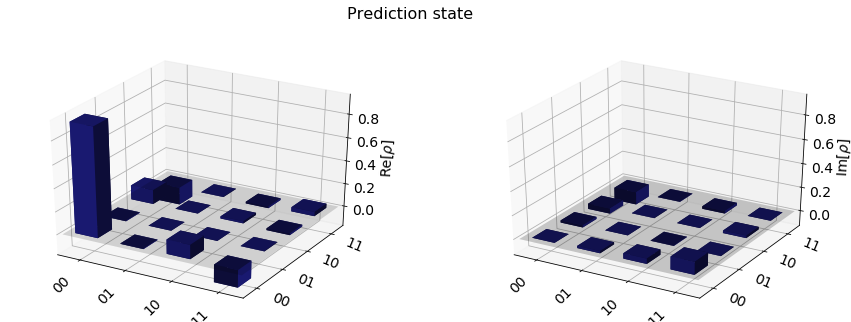

In [189]:
fid_1,fid_2,fid_3,fid_4 ,state_vector = circuit_check_state_vector(var,test_x[0])
plot_state_city(state_vector, color=['midnightblue', 'midnightblue'],
     title="Prediction state ")

In [190]:
def predict_visualize(params,X,label):

    """
    this function takes only the weights "params" and a single sample from the data

    it returns a continous output ranging from 0 to 1. this requires rounding the output

    """

  
    print('Original label: ',label)
    fid_1,fid_2,fid_3,fid_4 = circuit_(params,X)
    predicted_val= np.argmax(np.array([fid_1,fid_2,fid_3,fid_4]))
    print('Predicted label: ',predicted_val)

  

In [191]:
predict_visualize(var,test_x[0],label_test[0])

Original label:  0
Predicted label:  0


In [192]:
predict_visualize(var,test_x[1],label_test[1])

Original label:  3
Predicted label:  3


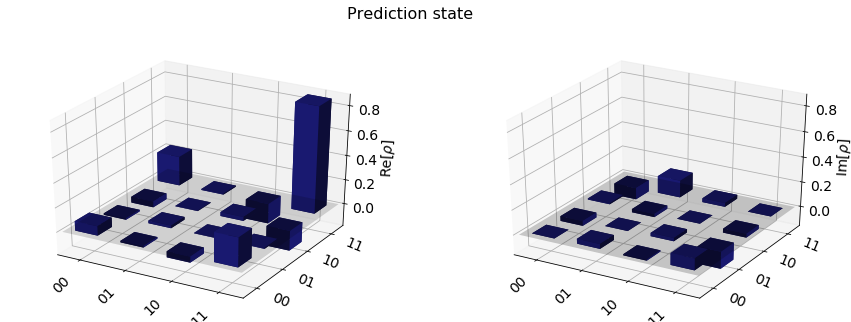

In [193]:
fid_1,fid_2,fid_3,fid_4 ,state_vector = circuit_check_state_vector(var,test_x[1])
plot_state_city(state_vector, color=['midnightblue', 'midnightblue'],
     title="Prediction state ")

In [194]:
predict_visualize(var,test_x[2],label_test[2])

Original label:  1
Predicted label:  1


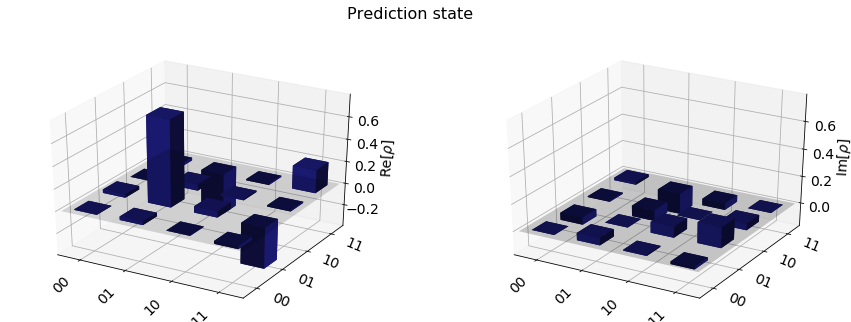

In [195]:
fid_1,fid_2,fid_3,fid_4 ,state_vector = circuit_check_state_vector(var,test_x[2])
plot_state_city(state_vector, color=['midnightblue', 'midnightblue'],
     title="Prediction state ")

In [196]:
predict_visualize(var,test_x[3],label_test[3])

Original label:  2
Predicted label:  2


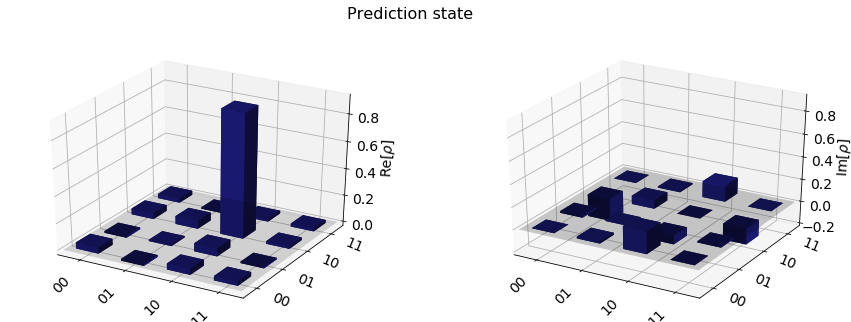

In [197]:
fid_1,fid_2,fid_3,fid_4 ,state_vector = circuit_check_state_vector(var,test_x[3])
plot_state_city(state_vector, color=['midnightblue', 'midnightblue'],
     title="Prediction state ")